In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/gesture.zip' -d 'data'

Archive:  /content/drive/MyDrive/gesture.zip
   creating: data/images/
   creating: data/images/1-palm/
  inflating: data/images/1-palm/1.jpg  
  inflating: data/images/1-palm/2.jpg  
  inflating: data/images/1-palm/3.jpg  
  inflating: data/images/1-palm/4.jpg  
  inflating: data/images/1-palm/5.jpg  
  inflating: data/images/1-palm/6.jpg  
  inflating: data/images/1-palm/7.jpg  
  inflating: data/images/1-palm/8.jpg  
  inflating: data/images/1-palm/9.jpg  
  inflating: data/images/1-palm/10.jpg  
  inflating: data/images/1-palm/11.jpg  
  inflating: data/images/1-palm/12.jpg  
  inflating: data/images/1-palm/13.jpg  
  inflating: data/images/1-palm/14.jpg  
  inflating: data/images/1-palm/15.jpg  
  inflating: data/images/1-palm/16.jpg  
  inflating: data/images/1-palm/17.jpg  
  inflating: data/images/1-palm/18.jpg  
  inflating: data/images/1-palm/19.jpg  
  inflating: data/images/1-palm/20.jpg  
  inflating: data/images/1-palm/21.jpg  
  inflating: data/images/1-palm/22.jpg  
  i

In [1]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
data_dir  = '/content/data/images/'
classes = os.listdir(data_dir)
print(classes)

['3-fist', '4-moved_fist', '2-L', '11-none', '1-palm', '9-c', '7-ok', '6-index', '10-down', '5-thumb', '8-moved_palm']


In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
data_tfms = (transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]))

In [4]:
dataset = ImageFolder(data_dir, data_tfms)

In [5]:
random_seed = 42
torch.manual_seed(random_seed);

In [6]:
val_size = 500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2800, 500)

In [7]:
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

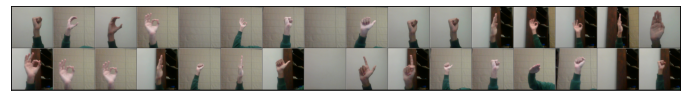

In [8]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
class gestureModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   #128

            nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #64

            nn.Conv2d(32,32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #32

            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #16

            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #8

            nn.Flatten(), 
            nn.Linear(128*8*8,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11))
        
    def forward(self, xb):
        return self.network(xb)

In [12]:
model = gestureModel()
model

gestureModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=8192, out

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);      #shifting data onto gpu

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
model = to_device(gestureModel(), device)

In [18]:
evaluate(model, val_dl)

{'val_acc': 0.08728966116905212, 'val_loss': 2.396811008453369}

In [19]:
num_epochs = 60
opt_func = torch.optim.Adam
lr = 0.00001

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 2.3983, val_loss: 2.3972, val_acc: 0.0873
Epoch [1], train_loss: 2.3967, val_loss: 2.3956, val_acc: 0.0847
Epoch [2], train_loss: 2.3913, val_loss: 2.3857, val_acc: 0.1345
Epoch [3], train_loss: 2.3679, val_loss: 2.3408, val_acc: 0.2227
Epoch [4], train_loss: 2.2746, val_loss: 2.1643, val_acc: 0.2572
Epoch [5], train_loss: 2.0122, val_loss: 1.8850, val_acc: 0.3595
Epoch [6], train_loss: 1.7018, val_loss: 1.5964, val_acc: 0.5224
Epoch [7], train_loss: 1.4044, val_loss: 1.2790, val_acc: 0.5999
Epoch [8], train_loss: 1.2129, val_loss: 1.1605, val_acc: 0.6364
Epoch [9], train_loss: 1.0717, val_loss: 1.1472, val_acc: 0.6846
Epoch [10], train_loss: 0.9683, val_loss: 0.9234, val_acc: 0.7194
Epoch [11], train_loss: 0.8617, val_loss: 0.8579, val_acc: 0.7139
Epoch [12], train_loss: 0.8056, val_loss: 0.8080, val_acc: 0.7734
Epoch [13], train_loss: 0.7600, val_loss: 0.7215, val_acc: 0.7811
Epoch [14], train_loss: 0.6864, val_loss: 0.7170, val_acc: 0.7925
Epoch [15], train_lo

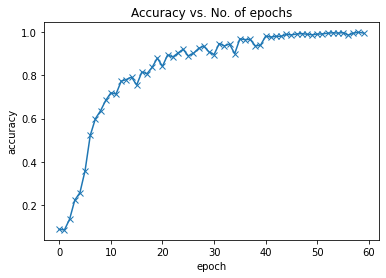

In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

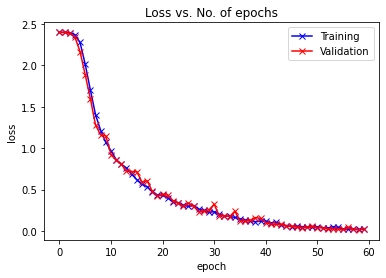

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [22]:
torch.save(model, '/content/drive/My Drive/WEIGHTS.pth')

In [23]:
model = torch.load('/content/drive/My Drive/WEIGHTS.pth')
model.eval()

gestureModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=8192, out